https://randerson112358.medium.com/stock-price-prediction-using-python-machine-learning-e82a039ac2bb

In [1]:
import math

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

In [57]:
df= pd.read_csv('./data/AXP_2010-01-01_to_2020-01-01.csv')

In [58]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AXP,2010-01-04 00:00:00+00:00,40.92,41.10,40.39,40.81,6894300,34.658048,34.810503,34.209154,34.564881,6894300,0.00,1.0
1,AXP,2010-01-05 00:00:00+00:00,40.83,41.23,40.37,40.83,10641200,34.581821,34.920609,34.192214,34.581821,10641200,0.00,1.0
2,AXP,2010-01-06 00:00:00+00:00,41.49,41.67,41.17,41.23,8399400,35.140822,35.293276,34.869791,34.920609,8399400,0.00,1.0
3,AXP,2010-01-07 00:00:00+00:00,41.98,42.24,41.11,41.26,8981700,35.708292,35.929449,34.968268,35.095858,8981700,0.18,1.0
4,AXP,2010-01-08 00:00:00+00:00,41.95,42.48,41.40,41.76,7907700,35.682774,36.133593,35.214943,35.521159,7907700,0.00,1.0


In [59]:
df["date"] = pd.to_datetime(df["date"])


In [60]:
df.drop(columns=["symbol"], inplace=True)

In [61]:
df.set_index("date", inplace=True)

In [63]:
df=df[df.index<pd.Timestamp("2020-01-1 0:00:00", tz="Europe/Brussels")]
df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2010-01-04 00:00:00+00:00,40.92,41.10,40.39,40.81,6894300,34.658048,34.810503,34.209154,34.564881,6894300,0.00,1.0
2010-01-05 00:00:00+00:00,40.83,41.23,40.37,40.83,10641200,34.581821,34.920609,34.192214,34.581821,10641200,0.00,1.0
2010-01-06 00:00:00+00:00,41.49,41.67,41.17,41.23,8399400,35.140822,35.293276,34.869791,34.920609,8399400,0.00,1.0
2010-01-07 00:00:00+00:00,41.98,42.24,41.11,41.26,8981700,35.708292,35.929449,34.968268,35.095858,8981700,0.18,1.0
2010-01-08 00:00:00+00:00,41.95,42.48,41.40,41.76,7907700,35.682774,36.133593,35.214943,35.521159,7907700,0.00,1.0


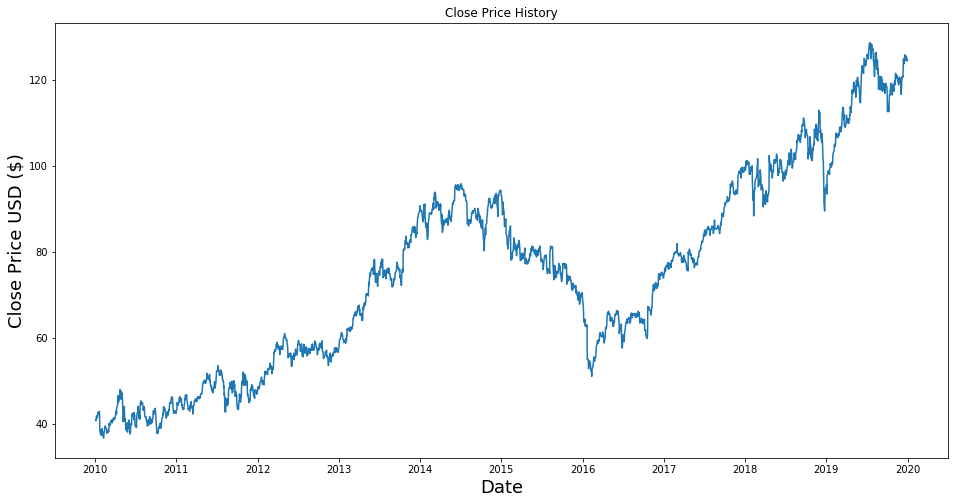

In [64]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [65]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
# training_data_len = math.ceil( len(dataset) *.8) 
training_data_len = len(df[df.index<=pd.Timestamp("2019-01-1 0:00:00", tz="Europe/Brussels")])


In [66]:
training_df=data[:training_data_len]


In [67]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [68]:
data["scaled_close"]=scaled_data


In [69]:
moving_avg = data.scaled_close.rolling(60, min_periods=60).mean()

In [70]:
exponential_moving_avg = data.scaled_close.ewm(alpha=0.1, adjust=False).mean()

In [71]:
cumulative_moving_avg = data.scaled_close.expanding().mean()

In [72]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
train_data_unscaled = dataset[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
y_train_simple = []

for i in range(60,len(train_data)):

    x_train.append(np.append(train_data[i-60:i,0], (moving_avg[i], exponential_moving_avg[i], cumulative_moving_avg[i])))


    y_train.append(train_data[i,0])
    y_train_simple.append(np.sign(train_data_unscaled[i,0]- train_data_unscaled[i-1,0]))

In [73]:
#Convert x_train and y_train to numpy arrays
x_train, y_train, y_train_simple = np.array(x_train), np.array(y_train), np.array(y_train_simple)


In [74]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [75]:
x_train.shape


(2204, 63, 1)

In [86]:
import talos


def hyper(x_train, y_train,x_val, y_val, params):

    model = Sequential()
    model.add(LSTM(units=params['units_first_layer'], return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=params['units_first_layer'], return_sequences=False))
    model.add(Dense(units=params['units_second_layer']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(units=1))
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
    model.compile(optimizer=params['optimizer'], loss=['mean_squared_error'], metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None)])
    history = model.fit(x_train, y_train, epochs=4,batch_size=params['batch_size'], validation_data=(x_val, y_val),
                        shuffle=False,callbacks=[callback])


    return history, model

In [102]:

p = {
    'units_first_layer':[50, 100],
    'units_second_layer':[10,25],
    'dropout': [0, 0.3],
     'batch_size': [1, 10],
     'optimizer': [ 'Adam'],
#      'metric':[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None) ]
}

In [103]:

# p = {
#     'units_first_layer':[50],
#     'units_second_layer':[25],
#     'dropout': [0],
#      'batch_size': [1],
#     'epochs': [1],
#      'optimizer': ['Adam'],
#      'losses': ['mean_squared_error'],
#      'metric':[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None) ]
# }

In [105]:
validation_split=math.ceil( len(x_train) *.6)
t = talos.Scan(x=x_train[:validation_split], 
               y=y_train[:validation_split],
               x_val=x_train[validation_split:], 
               y_val=y_train[validation_split:],
               model=hyper,
               params=p,
               print_params=True,
               experiment_name='stock')
# t = talos.Scan(x=x_train,
#                y=y_train,
#                model=hyper,
#                params=p,
#                print_params=True,
#                experiment_name='stock')




  0%|          | 0/16 [00:00<?, ?it/s]

{'batch_size': 1, 'dropout': 0, 'optimizer': 'Adam', 'units_first_layer': 50, 'units_second_layer': 10}


  0%|          | 0/64 [53:16<?, ?it/s]


Epoch 1/4
1323/1323 [==============================] - 45s 34ms/step - loss: 4.3876e-04 - root_mean_squared_error: 0.0209 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1694
Epoch 2/4
1323/1323 [==============================] - 41s 31ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1681




  6%|▋         | 1/16 [01:30<22:41, 90.78s/it]

{'batch_size': 1, 'dropout': 0, 'optimizer': 'Adam', 'units_first_layer': 50, 'units_second_layer': 25}
Epoch 1/4
1323/1323 [==============================] - 45s 34ms/step - loss: 4.7505e-04 - root_mean_squared_error: 0.0218 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1699
Epoch 2/4
1323/1323 [==============================] - 42s 32ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1706




 12%|█▎        | 2/16 [03:01<21:11, 90.80s/it]

{'batch_size': 1, 'dropout': 0, 'optimizer': 'Adam', 'units_first_layer': 100, 'units_second_layer': 10}
Epoch 1/4
1323/1323 [==============================] - 48s 36ms/step - loss: 4.0793e-04 - root_mean_squared_error: 0.0202 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1698
Epoch 2/4
1323/1323 [==============================] - 48s 36ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1652




 19%|█▉        | 3/16 [04:41<20:14, 93.41s/it]

{'batch_size': 1, 'dropout': 0, 'optimizer': 'Adam', 'units_first_layer': 100, 'units_second_layer': 25}
Epoch 1/4
1323/1323 [==============================] - 48s 36ms/step - loss: 4.0598e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1690
Epoch 2/4
1323/1323 [==============================] - 47s 36ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1682




 25%|██▌       | 4/16 [06:19<18:59, 94.95s/it]

{'batch_size': 1, 'dropout': 0.3, 'optimizer': 'Adam', 'units_first_layer': 50, 'units_second_layer': 10}
Epoch 1/4
1323/1323 [==============================] - 42s 32ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - val_loss: 0.0279 - val_root_mean_squared_error: 0.1671
Epoch 2/4
1323/1323 [==============================] - 40s 30ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1644




 31%|███▏      | 5/16 [07:44<16:52, 92.00s/it]

{'batch_size': 1, 'dropout': 0.3, 'optimizer': 'Adam', 'units_first_layer': 50, 'units_second_layer': 25}
Epoch 1/4
1323/1323 [==============================] - 43s 33ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1722
Epoch 2/4
1323/1323 [==============================] - 40s 30ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1684




 38%|███▊      | 6/16 [09:11<15:03, 90.36s/it]

{'batch_size': 1, 'dropout': 0.3, 'optimizer': 'Adam', 'units_first_layer': 100, 'units_second_layer': 10}
Epoch 1/4
1323/1323 [==============================] - 48s 36ms/step - loss: 0.0027 - root_mean_squared_error: 0.0515 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1694
Epoch 2/4
1323/1323 [==============================] - 48s 36ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1699




 44%|████▍     | 7/16 [10:50<13:56, 92.98s/it]

{'batch_size': 1, 'dropout': 0.3, 'optimizer': 'Adam', 'units_first_layer': 100, 'units_second_layer': 25}
Epoch 1/4
1323/1323 [==============================] - 48s 36ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705
Epoch 2/4
1323/1323 [==============================] - 49s 37ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1691




 50%|█████     | 8/16 [12:29<12:39, 94.96s/it]

{'batch_size': 10, 'dropout': 0, 'optimizer': 'Adam', 'units_first_layer': 50, 'units_second_layer': 10}
Epoch 1/4
133/133 [==============================] - 7s 56ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 2/4
133/133 [==============================] - 6s 48ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1265




 56%|█████▋    | 9/16 [12:47<08:22, 71.78s/it]

{'batch_size': 10, 'dropout': 0, 'optimizer': 'Adam', 'units_first_layer': 50, 'units_second_layer': 25}
Epoch 1/4
133/133 [==============================] - 7s 55ms/step - loss: 0.0017 - root_mean_squared_error: 0.0406 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 2/4
133/133 [==============================] - 7s 49ms/step - loss: 0.0037 - root_mean_squared_error: 0.0606 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1483




 62%|██████▎   | 10/16 [13:05<05:33, 55.58s/it]

{'batch_size': 10, 'dropout': 0, 'optimizer': 'Adam', 'units_first_layer': 100, 'units_second_layer': 10}
Epoch 1/4
133/133 [==============================] - 8s 61ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 2/4
133/133 [==============================] - 7s 55ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1361




 69%|██████▉   | 11/16 [13:24<03:43, 44.76s/it]

{'batch_size': 10, 'dropout': 0, 'optimizer': 'Adam', 'units_first_layer': 100, 'units_second_layer': 25}
Epoch 1/4
133/133 [==============================] - 8s 63ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 2/4
133/133 [==============================] - 7s 56ms/step - loss: 0.0033 - root_mean_squared_error: 0.0573 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1538




 75%|███████▌  | 12/16 [13:44<02:28, 37.25s/it]

{'batch_size': 10, 'dropout': 0.3, 'optimizer': 'Adam', 'units_first_layer': 50, 'units_second_layer': 10}
Epoch 1/4
133/133 [==============================] - 7s 55ms/step - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 2/4
133/133 [==============================] - 6s 48ms/step - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242




 81%|████████▏ | 13/16 [14:02<01:34, 31.36s/it]

{'batch_size': 10, 'dropout': 0.3, 'optimizer': 'Adam', 'units_first_layer': 50, 'units_second_layer': 25}
Epoch 1/4
133/133 [==============================] - 7s 55ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314
Epoch 2/4
133/133 [==============================] - 6s 48ms/step - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1373




 88%|████████▊ | 14/16 [14:20<00:54, 27.27s/it]

{'batch_size': 10, 'dropout': 0.3, 'optimizer': 'Adam', 'units_first_layer': 100, 'units_second_layer': 10}
Epoch 1/4
133/133 [==============================] - 8s 61ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 2/4
133/133 [==============================] - 7s 55ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1581




 94%|█████████▍| 15/16 [14:39<00:24, 24.91s/it]

{'batch_size': 10, 'dropout': 0.3, 'optimizer': 'Adam', 'units_first_layer': 100, 'units_second_layer': 25}
Epoch 1/4
133/133 [==============================] - 8s 64ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0936
Epoch 2/4
133/133 [==============================] - 7s 56ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1331




100%|██████████| 16/16 [14:59<00:00, 56.21s/it]


In [106]:
analyze_object = talos.Analyze(t)


In [107]:
t.data[t.data.val_root_mean_squared_error==analyze_object.low('val_root_mean_squared_error')]

,start,end,duration,round_epochs,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,batch_size,dropout,optimizer,units_first_layer,units_second_layer
12,12/25/20-191006,12/25/20-191024,17.220162,2,0.006745,0.082129,0.015426,0.124202,10,0.3,Adam,50,10


In [108]:
analyze_object.low('val_root_mean_squared_error')


0.12420234829187393

In [ ]:
# #Build the LSTM network model
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
# model.add(LSTM(units=50, return_sequences=False))
# model.add(Dense(units=25))
# model.add(Dense(units=1))

# #Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# #Train the model
# model.fit(x_train, y_train, batch_size=1, epochs=1)

In [109]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
moving_avg_test= moving_avg[training_data_len-61:]
exponential_moving_avg_test= exponential_moving_avg[training_data_len-61:]
cumulative_moving_avg_test = cumulative_moving_avg[training_data_len-61:]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ]
y_test_simple = np.sign(y_test)
for i in range(60,len(test_data)):
    
    x_test.append(np.append(test_data[i-60:i,0],(moving_avg_test[i],exponential_moving_avg_test[i],cumulative_moving_avg_test[i])))

    
#Convert x_test to a numpy array 
x_test = np.array(x_test)  

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [79]:
# #Getting the models predicted price values
# predictions = model.predict(x_test) 
# predictions = scaler.inverse_transform(predictions)#Undo scaling

In [110]:
# predictions = t.best_model(metric='root_mean_squared_error', asc=True).predict(x_test) 
predictions = t.best_model(metric='val_root_mean_squared_error', asc=True).predict(x_test) 
predictions = scaler.inverse_transform(predictions)


In [111]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse



28.17435860694617

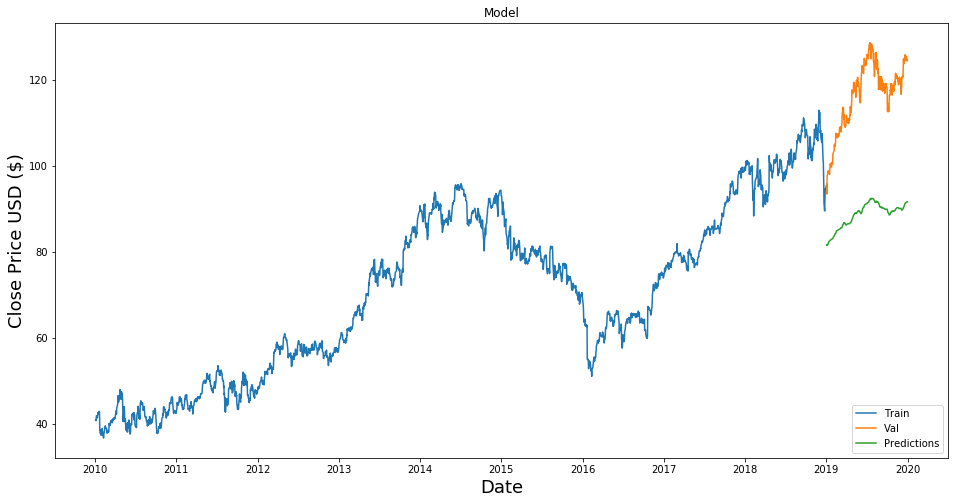

In [112]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()